In [ ]:
# Baza de date FERET (I) + PCA + MLP 6 nivele ascunse

In [ ]:
pip install mlxtend==0.18.0

In [ ]:
import mlxtend                                                          
print(mlxtend.__version__)   

0.18.0


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report

from keras import models
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics

from keras.models import Sequential

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras import regularizers
from keras.regularizers import l1,l2

In [ ]:
path = '/content/drive/MyDrive/facultate/ICI1_proiect/'
os.listdir(path)

['example_submission.csv',
 'fer2013.tar.gz',
 'icml_face_data.csv',
 'test.csv',
 'train.csv']

In [ ]:
data = pd.read_csv(path+'/icml_face_data.csv')

In [ ]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
data.shape

(35887, 3)

In [ ]:
def prepare_data(data):
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
  
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [ ]:
data[' Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name:  Usage, dtype: int64

In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [ ]:
train_image_label[:10]

array([0, 0, 2, 4, 6, 2, 4, 3, 3, 2])

In [ ]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [ ]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [ ]:
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


In [ ]:
train_imagini = train_images.reshape(train_images.shape[0],train_images.shape[1]*train_images.shape[2])
test_imagini = test_images.reshape(test_images.shape[0],test_images.shape[1]*test_images.shape[2])

In [ ]:
pca = PCA(n_components= 20).fit(train_imagini)
 

X_train_pca = pca.transform(train_imagini)
X_test_pca = pca.transform(test_imagini)
print(X_train_pca.shape)

(28709, 20)


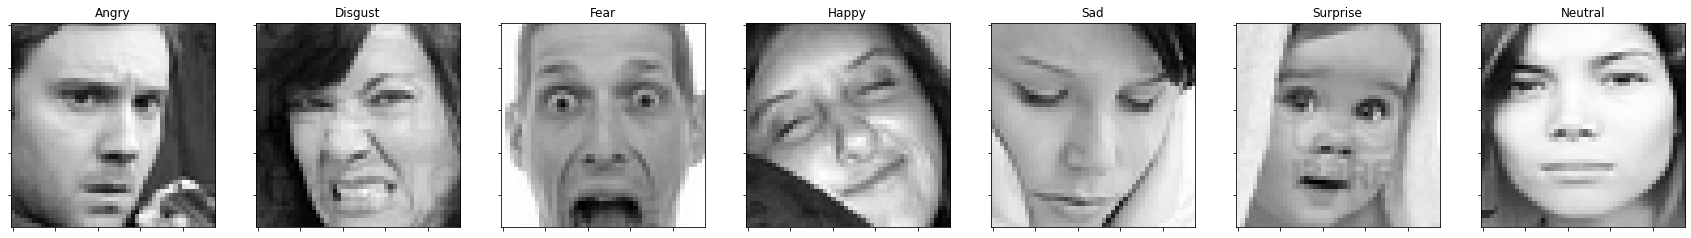

In [ ]:
plot_all_emotions()

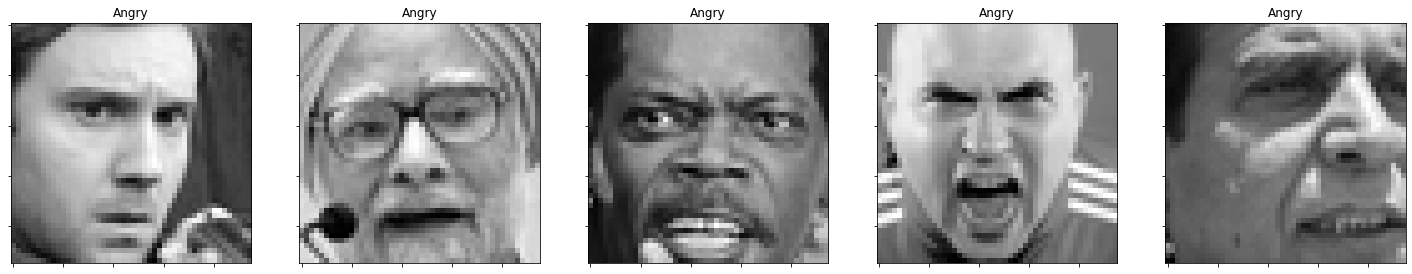

In [ ]:
plot_examples(label=0)

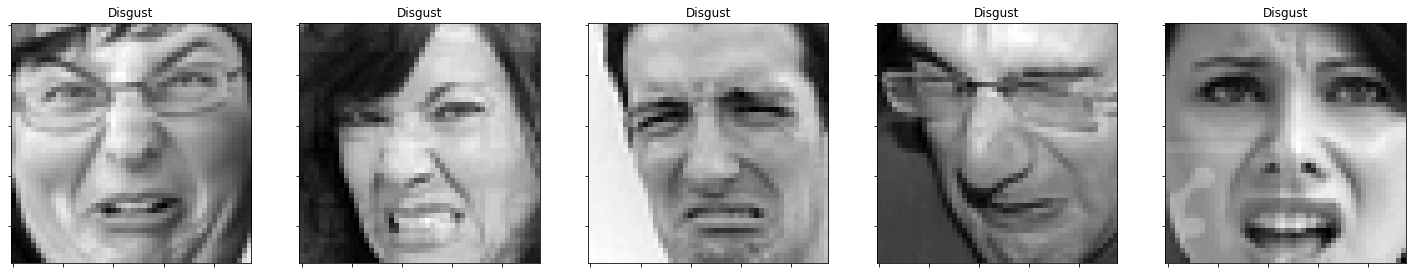

In [ ]:
plot_examples(label=1)

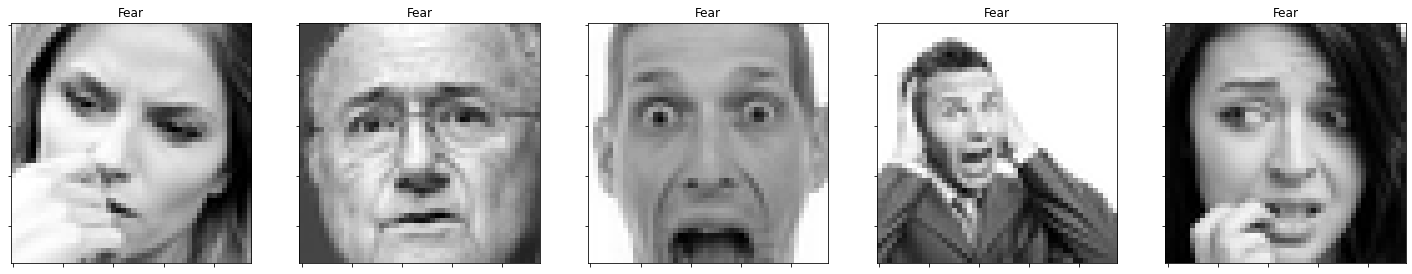

In [ ]:
plot_examples(label=2)

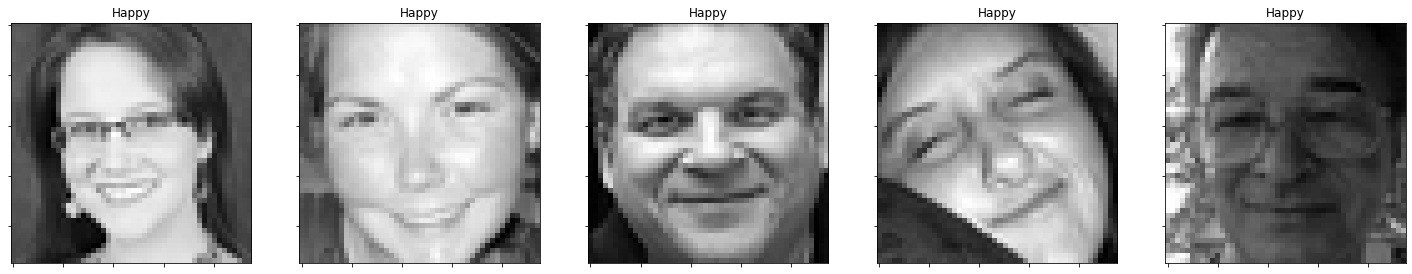

In [ ]:
plot_examples(label=3)

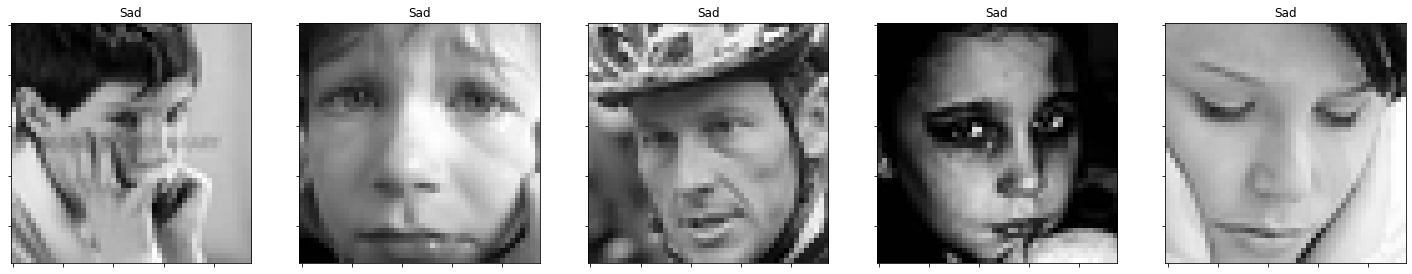

In [ ]:
plot_examples(label=4)

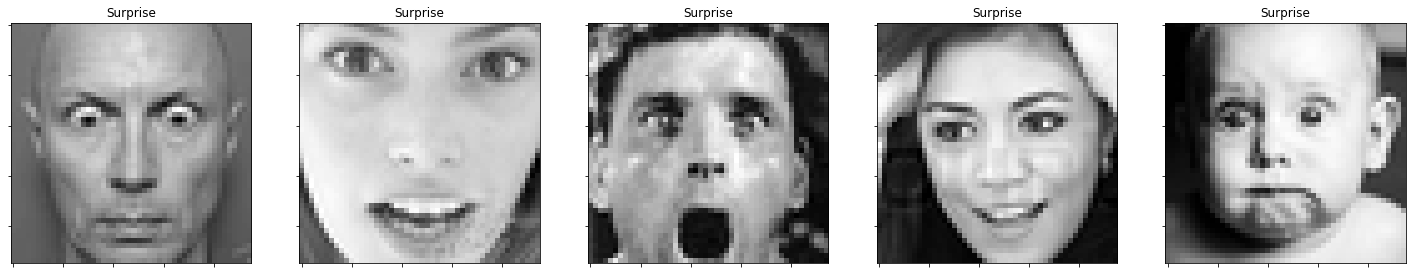

In [ ]:
plot_examples(label=5)

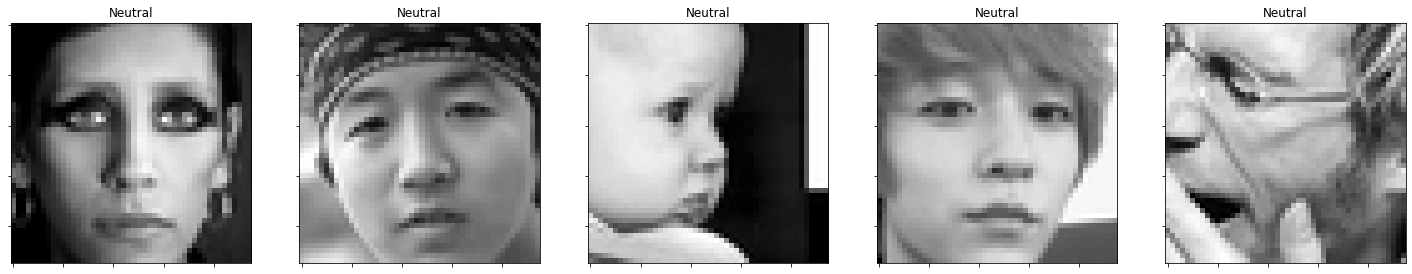

In [ ]:
plot_examples(label=6)

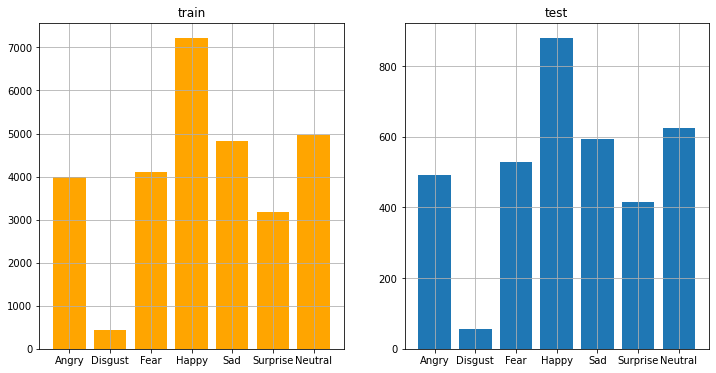

In [ ]:
plot_compare_distributions(train_labels, val_labels, title1='train', title2='test')

PCA
PCA pe train set

In [ ]:
cov_matrix_train = np.copy(train_imagini)
print(cov_matrix_train.mean(axis=0).shape)
cov_matrix_train -= cov_matrix_train.mean(axis=0)
N = cov_matrix_train.shape[0] 
cov_matrix_train = np.dot(cov_matrix_train.T, cov_matrix_train.conj()) / float(N - 1)

(2304,)


In [ ]:
eig_val, eig_vec = np.linalg.eig(cov_matrix_train)

In [ ]:
eig_val[:50]

array([40.94094   , 13.880236  , 13.385017  ,  7.763982  ,  4.3138022 ,
        3.6485245 ,  3.0788572 ,  2.7849522 ,  2.5253463 ,  2.1397645 ,
        1.663671  ,  1.5055885 ,  1.4456267 ,  1.4167023 ,  1.3079631 ,
        1.1581677 ,  1.1171799 ,  0.93319976,  0.77786547,  0.7594847 ,
        0.7549189 ,  0.707487  ,  0.69424564,  0.65908337,  0.6257836 ,
        0.5902104 ,  0.5797171 ,  0.538961  ,  0.48853204,  0.47908366,
        0.46173495,  0.44852352,  0.43929204,  0.43159193,  0.4249638 ,
        0.4012474 ,  0.3886277 ,  0.36334017,  0.35293323,  0.35064265,
        0.32598352,  0.3115206 ,  0.30373013,  0.29098818,  0.28917325,
        0.2839658 ,  0.27176562,  0.25916418,  0.25761253,  0.25360563],
      dtype=float32)

In [ ]:
retain_value = sum(eig_val[:200])/(sum(eig_val))
print(100* retain_value)

93.87275236385281


In [ ]:
eig_vec_filtered = eig_vec[:, :200]

In [ ]:
X_train_pca = eig_vec_filtered.T.dot(train_imagini.T)
X_train_pca = X_train_pca.T

In [ ]:
X_train_pca.shape

(28709, 200)

PCA pe test set

In [ ]:
cov_matrix_test = np.copy(test_imagini)
cov_matrix_test -= cov_matrix_test.mean(axis=0)
N = cov_matrix_test.shape[0] 
cov_matrix_test = np.dot(cov_matrix_test.T, cov_matrix_test.conj()) / float(N - 1)

In [ ]:
eig_val, eig_vec = np.linalg.eig(cov_matrix_test)

In [ ]:
retain_value = sum(eig_val[:200])/(sum(eig_val))
print(100* retain_value)
eig_vec_filtered = eig_vec[:, :200]

94.32035562392164


In [ ]:
X_test_pca = eig_vec_filtered.T.dot(test_imagini.T)
X_test_pca = X_test_pca.T

In [ ]:
X_test_pca.shape

(3589, 50)

MLP

In [ ]:
model=Sequential()
model.add(Dense(20, activation='relu', input_dim=20,kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))


model.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

epochs=200
batch_size=256
	
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=6, min_lr=0.001)
model.compile(optimizer=Adam(lr=1e-3),loss='kullback_leibler_divergence',metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_14 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_15 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_16 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)               

In [ ]:
History = model.fit(X_train_pca,train_labels, callbacks=[es,reduce_lr],epochs = epochs, validation_data = (X_test_pca,test_labels),batch_size=batch_size, verbose = 1)

In [ ]:
test_loss, test_acc = model.evaluate(X_test_pca, test_labels)
print('test accuracy:', test_acc)

113/113 [==============================] - 0s 919us/step - loss: 1.5448 - accuracy: 0.4132
test accuracy: 0.4132070243358612


In [ ]:
train_loss, train_acc = model.evaluate(X_train_pca, train_labels)
print('train accuracy:', train_acc)

898/898 [==============================] - 1s 873us/step - loss: 1.4629 - accuracy: 0.4506
train accuracy: 0.4505904018878937


Rezultate

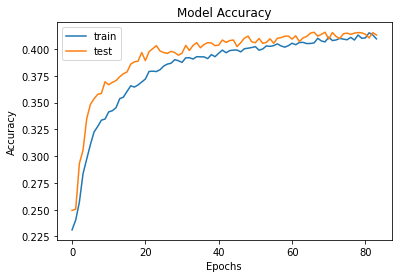

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


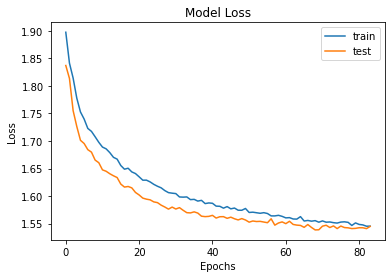

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
predict_labels=model.predict(X_test_pca) 
predict_class=np.argmax(model.predict(X_test_pca), axis=-1)

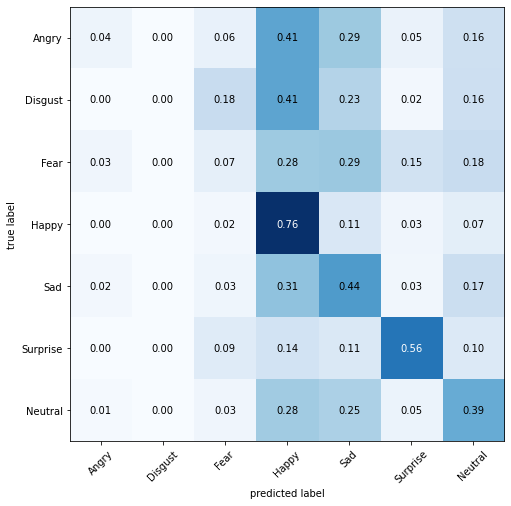

In [ ]:
conf_mat = confusion_matrix(test_image_label, predict_class)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

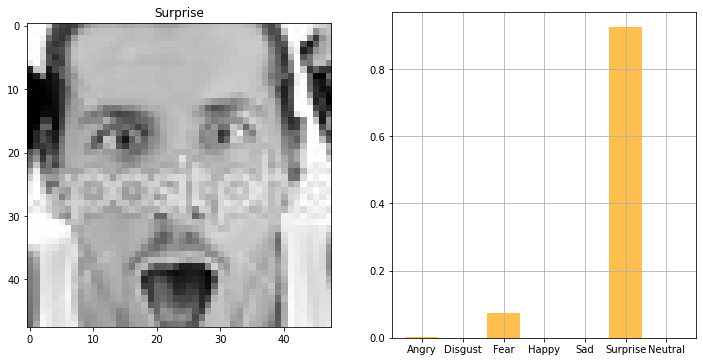

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, predict_labels, 64)

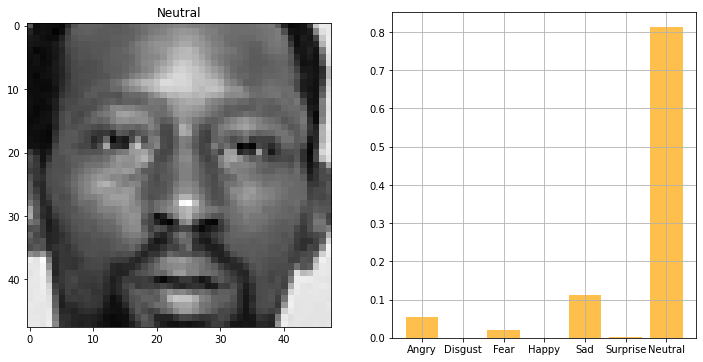

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, predict_labels, 33)

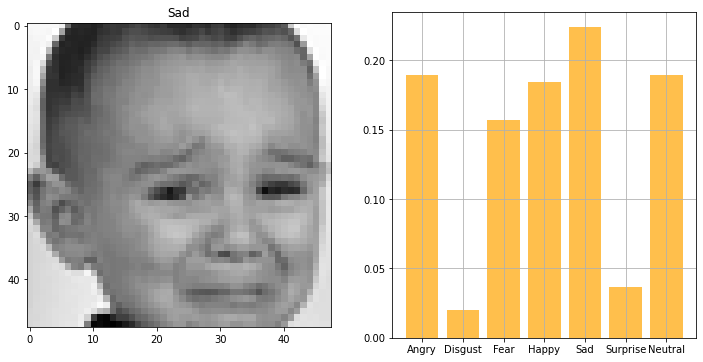

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, predict_labels, 78)

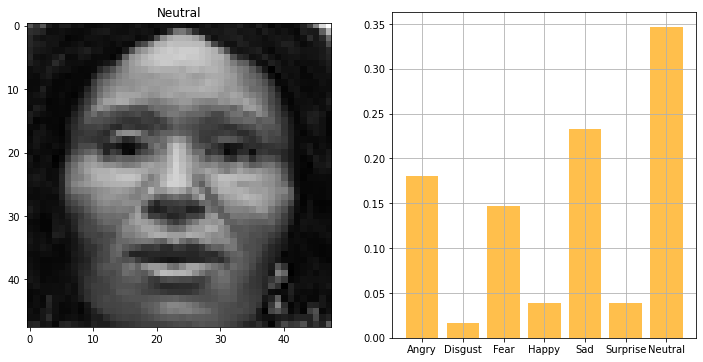

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, predict_labels, 72)

In [ ]:
predict_class=np.argmax(model.predict(X_test_pca), axis=-1)
print(classification_report(test_image_label, predict_class, target_names=emotions.values()))

              precision    recall  f1-score   support

       Angry       0.48      0.02      0.04       467
     Disgust       0.00      0.00      0.00        56
        Fear       0.22      0.20      0.21       496
       Happy       0.51      0.68      0.58       895
         Sad       0.32      0.46      0.38       653
    Surprise       0.57      0.56      0.57       415
     Neutral       0.35      0.33      0.34       607

    accuracy                           0.41      3589
   macro avg       0.35      0.32      0.30      3589
weighted avg       0.40      0.41      0.37      3589



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


pca = PCA(n_components=600, whiten=True)
X_train = pca.fit_transform(train_imagini)
X_test = pca.transform(test_imagini)
plt.plot(range(1,601), pca.explained_variance_ratio_.cumsum())
plt.title('Explained Variance',fontsize=15)
plt.xlabel('Number of Principle Components', fontsize=10)
plt.show()

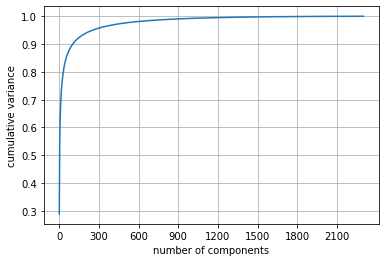

In [ ]:
pca = PCA().fit(train_imagini)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative variance');
plt.xticks(np.arange(0, 2304, 300))
plt.grid(b=True)

END

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(50,40,40,40,40,40,40,7), batch_size=256, verbose=True, early_stopping=True).fit(X_train_pca, train_image_label)


Iteration 1, loss = 1.80205583
Validation score: 0.307210
Iteration 2, loss = 1.67807476
Validation score: 0.346569
Iteration 3, loss = 1.63129817
Validation score: 0.361895
Iteration 4, loss = 1.60428320
Validation score: 0.362243
Iteration 5, loss = 1.58540737
Validation score: 0.367119
Iteration 6, loss = 1.56682678
Validation score: 0.374782
Iteration 7, loss = 1.54852870
Validation score: 0.379310
Iteration 8, loss = 1.53446790
Validation score: 0.388018
Iteration 9, loss = 1.51945448
Validation score: 0.394984
Iteration 10, loss = 1.50530259
Validation score: 0.393243
Iteration 11, loss = 1.49309424
Validation score: 0.384535
Iteration 12, loss = 1.47919039
Validation score: 0.392198
Iteration 13, loss = 1.47258268
Validation score: 0.381052
Iteration 14, loss = 1.45816026
Validation score: 0.384535
Iteration 15, loss = 1.44629318
Validation score: 0.386625
Iteration 16, loss = 1.44071745
Validation score: 0.385232
Iteration 17, loss = 1.42916806
Validation score: 0.386625
Iterat

In [ ]:
y_pred = clf.predict(X_test_pca)
pred_test_labels = clf.predict_proba(X_test_pca)

print(classification_report(test_image_label, y_pred, target_names=emotions.values()))

              precision    recall  f1-score   support

       Angry       0.25      0.12      0.16       467
     Disgust       0.00      0.00      0.00        56
        Fear       0.26      0.11      0.16       496
       Happy       0.46      0.70      0.56       895
         Sad       0.32      0.38      0.35       653
    Surprise       0.50      0.52      0.51       415
     Neutral       0.34      0.34      0.34       607

    accuracy                           0.39      3589
   macro avg       0.31      0.31      0.30      3589
weighted avg       0.36      0.39      0.36      3589



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 88)

In [ ]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

In [ ]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

Text(0.5, 1.0, 'Average Face')

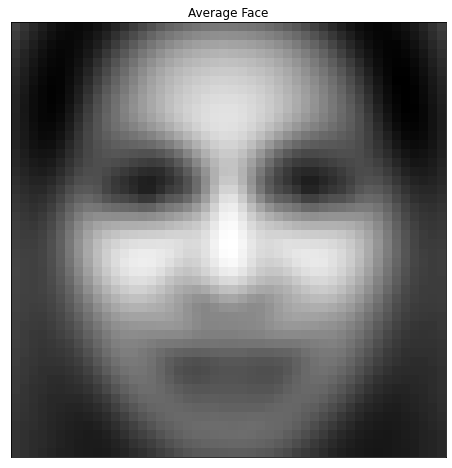

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.imshow(pca.mean_.reshape((48,48)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

In [ ]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from sklearn.model_selection import KFold



inputs = np.concatenate((X_train_pca, X_test_pca), axis=0)
targets = np.concatenate((train_image_label, test_image_label), axis=0)
num_folds=10
input_shape=200

kfold = KFold(n_splits=num_folds, shuffle=True)
acc_per_fold = []
loss_per_fold = []

fold_no = 1
for train, test in kfold.split(inputs, targets):

  
  model=Sequential()
  model.add(Dense(200, activation='relu', input_dim=200,kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.2))


  model.add(Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.2))
  model.add(Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.2))
  model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.2))
  model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.2))
  model.add(Dense(20, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.2))
  model.add(Dense(20, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Dropout(0.2))

  model.add(Dense(7, activation='softmax'))




  
  model.compile(optimizer=Adam(lr=1e-3),loss='kullback_leibler_divergence',metrics=['accuracy'])
  # es = EarlyStopping(monitor='', mode='min', verbose=1, patience=10)

  
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')


  history = model.fit(inputs[train], targets[train],
              batch_size=256,
              epochs=40,
              verbose=1)

  
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
114/114 [==============================] - 2s 8ms/step - loss: 11.7999 - accuracy: 0.1475
Epoch 2/40
114/114 [==============================] - 1s 9ms/step - loss: 11.8024 - accuracy: 0.1566
Epoch 3/40
114/114 [==============================] - 1s 9ms/step - loss: 11.7669 - accuracy: 0.1657
Epoch 4/40
114/114 [==============================] - 1s 9ms/step - loss: 11.7553 - accuracy: 0.1998
Epoch 5/40
114/114 [==============================] - 1s 9ms/step - loss: 11.7305 - accuracy: 0.1861
Epoch 6/40
114/114 [==============================] - 1s 9ms/step - loss: 11.7775 - accuracy: 0.1832
Epoch 7/40
114/114 [==============================] - 1s 9ms/step - loss: 11.7282 - accuracy: 0.2030
Epoch 8/40
114/114 [==============================] - 1s 8ms/step - loss: 11.7728 - accuracy: 0.1643
Epoch 9/40
114/114 [==============================] - 1s 9ms/step - loss: 11.6767 - accuracy: 0

KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import KFold

n_split=3

for train_index,test_index in KFold(n_split).split(X_train_pca):
  x_train,x_test=X_train_pca[train_index],X_test_pca[test_index]
  y_train,y_test=train_image_label[train_index],test_image_label[test_index]
  
  
  model.fit(x_train, y_train,epochs=30)
  
  print('Model evaluation ',model.evaluate(x_test,y_test))